In [ ]:
# CNN


In [66]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers, models
from keras import backend as K
from collections import namedtuple
import math
import matplotlib.pyplot as plt
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))

In [2]:
# LOAD DATA
dataframe = pd.read_csv('ML\data\dynamic_pus_using_pus50000_15PUs_201910_2616_25.txt', delimiter=',', header=None)
dataframe_max = pd.read_csv('ML\data\dynamic_pus_max_power50000_15PUs_201910_2616_25.txt', delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1]]], axis=1,
                        ignore_index=True)
idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)

data_reg = np.concatenate((dataframe_tot.values[:, 0:dataframe_tot.shape[1]-3], 
                           dataframe_tot.values[:, dataframe_tot.shape[1]-1:dataframe_tot.shape[1]]), axis=1)
data_class = dataframe_tot.values[:, 0:dataframe_tot.shape[1]-1]
y_class_power = dataframe_tot.values[:, -1]
del dataframe, dataframe_max

In [97]:
# INIT
number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 4001, 1000))
number_samples = [1]

In [165]:
def euclidian_distance(p1: point, p2: point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def create_image(data, pus_num, slope, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle', pu_param=None, 
                 su_shape='circle', su_param=None, intensity_degradation="log"):  
    # style = {"raw_power_z_score", "image_intensity"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_z_score": 
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        pu_image = [[0.] * max_y for _ in range(max_x)]
        for pu_i in range(pus_num):
            pu_x, pu_y, pu_p = max(0, min(max_x-1, int(data[pu_i*3]))), max(0, min(max_x-1, int(data[pu_i*3+1]))), data[pu_i*3+2]
            if pu_param is None:
                if pu_shape == 'circle':
                    if intensity_degradation == "linear":
                        pu_param = Circle(math.ceil((pu_p - noise_floor) / slope)) # linear
                    elif intensity_degradation == "log":
                        pu_param = Circle(math.ceil(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
                elif pu_shape == 'square':
                    if intensity_degradation == "linear":
                        pu_param = Square(math.ceil(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
                    elif intensity_degradation == "log":
                        pu_param = Square(math.ceil(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
                else:
                    raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        pu_image[point.p.x][point.p.y] += max((pu_p - slope * point.dist + abs(noise_floor))
                                                              /(pu_p + abs(noise_floor)), 0)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            pu_image[point.p.x][point.p.y] = 1
                        else:
                            pu_image[point.p.x][point.p.y] += max((pu_p - slope * 10*math.log10(point.dist) + abs(noise_floor))
                                                                 /(pu_p + abs(noise_floor)), 0)
                    pu_image[point.p.x][point.p.y] = min(pu_image[point.p.x][point.p.y], 1.0)
                        
        # creating SU image
        su_num = (len(data) - pus_num * 3) // 2
        if not (len(data) - pus_num * 3) % 2:
            raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        su_image = [[0.] * max_y for _ in range(max_x)]
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        su_intensity = 1.
        for su_i in range(su_num):
            su_x, su_y, su_p = max(0, min(max_x-1, int(data[pus_num*3+su_i*2]))
                                  ), max(0, min(max_x-1, int(data[pus_num*3+su_i*2+1]))), su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            for point in points:
                su_image[point.p.x][point.p.y] = su_intensity
#         return np.array([pu_image, su_image, [[0.] * max_y for _ in range(max_x)]], dtype='float32') # return like this to be able to display as an RGB image with pyplot.imshow(imsave)
        return np.array([pu_image, su_image], dtype='float32')
        
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set([Point(x, y) for x in range(-r, r+1) for y in range(-r, r+1)])
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
    
# TODO: Consider using min_max normalization becasue difference between values using
# z-score is huge since most of the pixels have the same value, noise floor

In [169]:
## CNN

average_class_diff_power = []
fp_mean_power = []
validation_size, noise_floor = 0.33, -90.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y = 4000, 4000
pu_shape, su_shape, su_param = 'circle', 'circle', Circle(10)
pus_num, intensity_degradation, slope = 15, 'linear', 2
num_pus = (data_reg.shape[1] - 3)//3
for number_sample in number_samples:
    sample = math.ceil(number_sample * (1 + validation_size))
    x_train, y_train = [], []
    for image_num in range(sample):
#         mu, sigma = calculate_mu_sigma(data_reg[image_num], num_pus)
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
#         for pu_n in range(num_pus):
#             x, y, p = max(0, min(max_x-1, int(data_reg[image_num][pu_n*3]))), max(0, min(max_x-1, int(data_reg[image_num][pu_n*3+1]))), data_reg[image_num][pu_n*3+2]
#             pu_image[x][y] = (p - mu)/sigma
#         su_image = [[noise_floor] * max_y for _ in range(max_x)]
#         su_x, su_y = max(0, min(max_x-1, int(data_reg[image_num][-3]))), max(0, min(max_x-1, int(data_reg[image_num][-2])))
#         su_image[su_x][su_y] = su_power
#         x_train.append(np.array([pu_image, su_image], dtype='float32'))
        x_train.append(create_image(data=data_reg[image_num], slope=slope, style="image_intensity", noise_floor=noise_floor,
                                    pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, pus_num=pus_num, 
                                    intensity_degradation=intensity_degradation))
        y_train.append(data_reg[image_num][-1])
    x_train = np.concatenate([image[np.newaxis] for image in x_train])
    y_train = np.asarray(y_train, dtype='float32')
    

In [82]:
print(pus_num, num_pus)

15 15


In [100]:
x_train.shape

(2, 3, 4000, 4000)

In [170]:
aa = np.swapaxes(x_train[0], 0, 2)

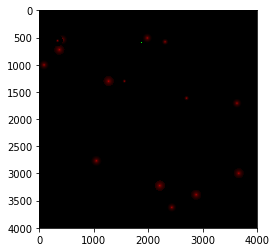

In [155]:
plt.imshow(aa)

In [171]:
plt.imsave('1113', aa)

In [14]:
# TODO, CNN Model here
num_filters = 1
data_format = 'channels_first'
cnn = models.Sequential()
cnn.add(layers.Conv2D(num_filters, (7, 7), activation='relu', input_shape=(2, 4000, 4000), data_format=data_format))
cnn.add(layers.MaxPooling2D(pool_size=(2,2), data_format=data_format))
cnn.add(layers.Conv2D(num_filters, (7, 7), activation='relu', data_format=data_format))
cnn.add(layers.MaxPool2D((2,2), data_format=data_format))
cnn.add(layers.Conv2D(num_filters, (7, 7), activation='relu', data_format=data_format))
cnn.add(layers.MaxPool2D((2,2), data_format=data_format))
cnn.add(layers.Conv2D(num_filters, (7, 7), activation='relu', data_format=data_format))
cnn.add(layers.MaxPool2D((2,2), data_format=data_format))
cnn.add(layers.Flatten())
# cnn.add(layers.Dense(10, activation='sigmoid'))
cnn.add(layers.Dense(1, activation='linear'))

In [15]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1, 3994, 3994)     99        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 1997, 1997)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 1991, 1991)     50        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 995, 995)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 989, 989)       50        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 494, 494)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 488, 488)       50        
__________

In [ ]:
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
cnn.fit(x_train, y_train, epochs=5, verbose=1)

Epoch 1/5
